##### Importing libraries

In [1]:
import os
import numpy as np
import pandas as pd
import itertools
from datetime import datetime
from scipy.stats import kruskal, mannwhitneyu
from statsmodels.stats.multitest import multipletests
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

##### CI Services and their corresponding YAML files

In [2]:
ci_services_config_files = {
    '.travis.yml': 'Travis CI',
    '.circleci/config.yml': 'CircleCI',
    'circle.yml': 'CircleCI',
    '.gitlab-ci.yml': 'GitLab CI',
    '.appveyor.yml': 'AppVeyor',
    'appveyor.yml': 'AppVeyor',
    'azure-pipelines.yml': 'Azure Pipelines',
    'bitbucket-pipelines.yml': 'Bitbucket Pipelines',
    '.cirrus.yml': 'Cirrus CI',
    '.github/workflows': 'GitHub Actions'
}

### Load all data files

In [3]:
# Load CI commits data
commits_data_path = os.path.join(os.getcwd(), '../data/java_commits_per_ci_files.csv')
df_ci_commits = pd.read_csv(commits_data_path, encoding='latin-1')
df_ci_commits['ci_service'] = df_ci_commits['configuration_file'].map(ci_services_config_files)

# Load contributors data
contributors_data_path = os.path.join(os.getcwd(), '../data/java_contributors.csv')
contributors_data = pd.read_csv(contributors_data_path)

# Load repo commit counts data
total_commits_path = os.path.join(os.getcwd(), '../data/java_repo_commit_counts.csv')
df_total_commits = pd.read_csv(total_commits_path)

# Load project details data
repo_details_path = os.path.join(os.getcwd(), '../data/java_repo_details.csv')
df_repo_details = pd.read_csv(repo_details_path)

# Load YAML stats data
yml_stats_path = os.path.join(os.getcwd(), '../data/java_ci_services_yml_stats.csv')
df_yml_stats = pd.read_csv(yml_stats_path)

# Load existence check data
ci_existence_path = os.path.join(os.getcwd(), '../data/java_ci_services_existence_check.csv')
df_ci_existence = pd.read_csv(ci_existence_path)

# Setting the results path
results_path = os.path.join(os.getcwd(), '../results')

# RQ1

### CI Service Adoption and Evolution.

##### Percentage of projects with 1,2,3,4,5,6 services together 

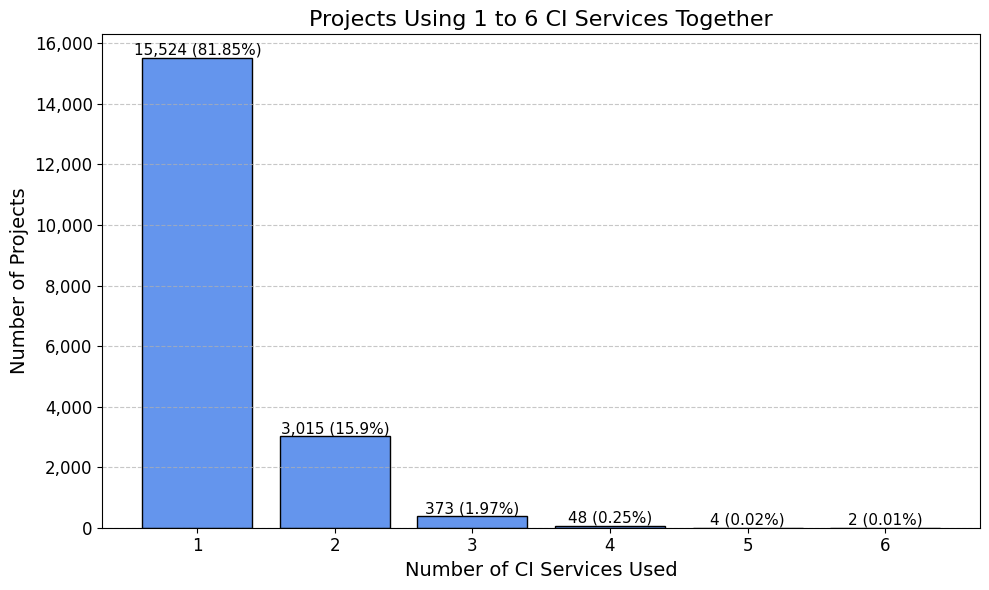

Number of repositories with two or more CI services: 3442


In [4]:
# Count number of unique CI services used per project
ci_count_per_repo = df_ci_commits.groupby('repo_name')['ci_service'].nunique()

# Count how many projects use 1 through 6 CI services
ci_usage_distribution = ci_count_per_repo.value_counts().sort_index()
filtered_usage = ci_usage_distribution.loc[[1, 2, 3, 4, 5, 6]]

# Calculate percentages
total_selected = filtered_usage.sum()
percentages = (filtered_usage / total_selected * 100).round(2)

# Create bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(filtered_usage.index.astype(str), filtered_usage.values,
               color='cornflowerblue', edgecolor='black')

# Add title and axis labels
plt.title('Projects Using 1 to 6 CI Services Together', fontsize=16)
plt.xlabel('Number of CI Services Used', fontsize=14)
plt.ylabel('Number of Projects', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x):,}"))

# Annotate each bar with count and percentage
for bar, pct in zip(bars, percentages):
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height + 10,
        f'{int(height):,} ({pct}%)',  # <-- Add :, for thousands separator
        ha='center',
        va='bottom',
        fontsize=11
    )

plt.tight_layout()
plt.show()

# Calculate number of repos with two or more CI services
num_multi_ci_repos = (ci_count_per_repo >= 2).sum()
print(f"Number of repositories with two or more CI services: {num_multi_ci_repos}")

##### Top CI Service Pairs Used Together

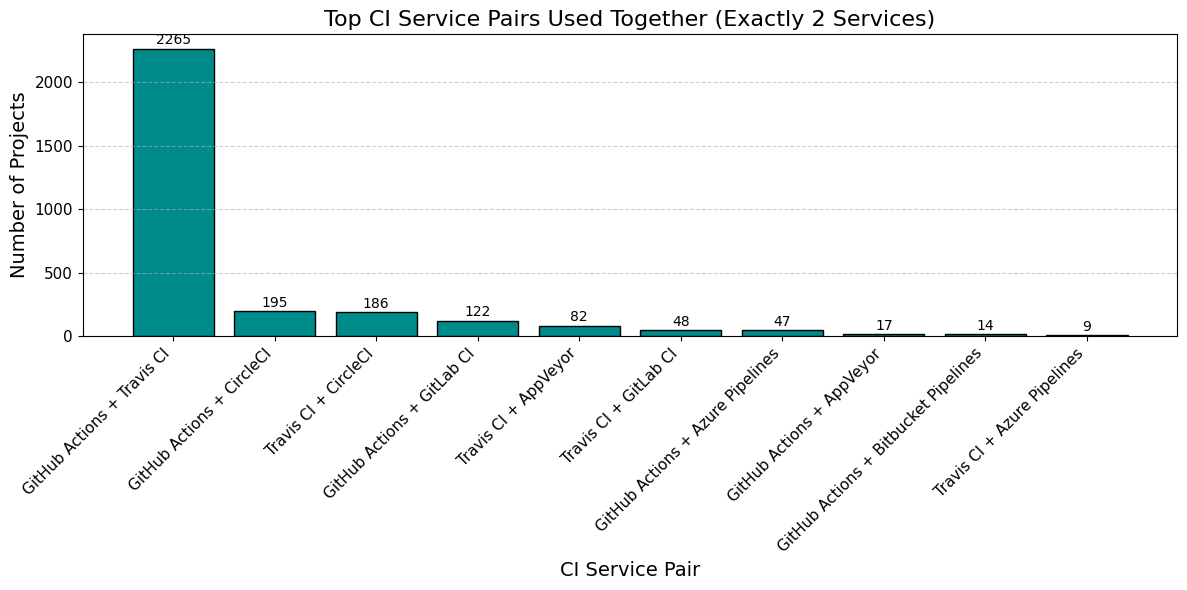

In [5]:
# Group by repo and get unique CI services used
repo_services = df_ci_commits.groupby('repo_name')['ci_service'].unique()

# Filter for projects using exactly 2 CI services
two_service_projects = repo_services[repo_services.apply(lambda x: len(x) == 2)]

# Count occurrences of each CI service pair
pair_counts = Counter(tuple(sorted(pair)) for pair in two_service_projects)

# Convert to DataFrame
pair_df = pd.DataFrame(pair_counts.items(), columns=['CI_Service_Pair', 'Count'])
pair_df = pair_df.sort_values(by='Count', ascending=False).reset_index(drop=True)

# Limit to top N pairs
top_n = 10
top_pairs = pair_df.head(top_n)

# Custom label function: prioritize GitHub Actions > Travis CI > CircleCI
def prioritized_label(pair):
    if 'GitHub Actions' in pair:
        first = 'GitHub Actions'
        second = pair[0] if pair[1] == 'GitHub Actions' else pair[1]
    elif 'Travis CI' in pair:
        first = 'Travis CI'
        second = pair[0] if pair[1] == 'Travis CI' else pair[1]
    elif 'CircleCI' in pair:
        first = 'CircleCI'
        second = pair[0] if pair[1] == 'CircleCI' else pair[1]
    else:
        first, second = pair
    return f'{first} + {second}'

# Apply custom labeling
labels = [prioritized_label(pair) for pair in top_pairs['CI_Service_Pair']]

# Plotting
plt.figure(figsize=(12, 6))
bars = plt.bar(labels, top_pairs['Count'], color='darkcyan', edgecolor='black')

# Add titles and labels
plt.title('Top CI Service Pairs Used Together (Exactly 2 Services)', fontsize=16)
plt.xlabel('CI Service Pair', fontsize=14)
plt.ylabel('Number of Projects', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=11)
plt.yticks(fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Annotate bars with count
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 10,
             f'{int(height)}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


##### Stacked Area Chart – CI Service Evolution Over Time

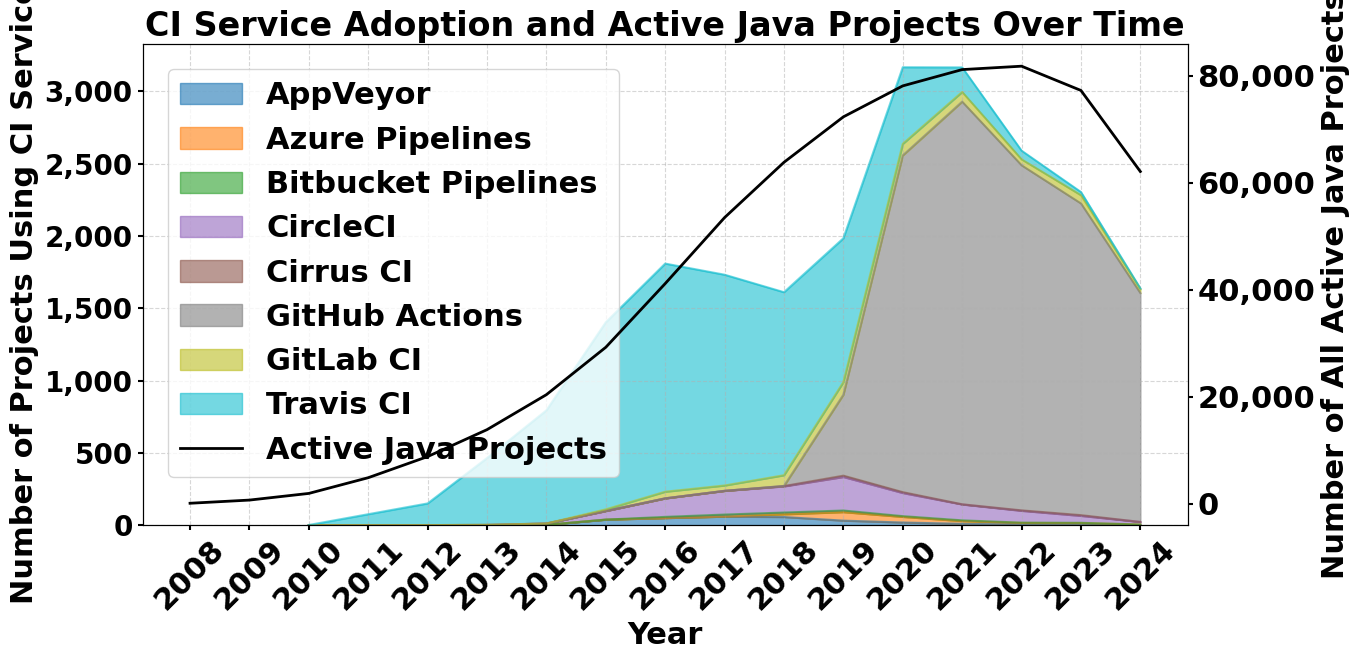

In [6]:
# Set global font settings
plt.rcParams.update({
    'font.size': 20,
    'font.weight': 'bold',
    'axes.titlesize': 20,
    'axes.labelsize': 20,
    'axes.labelweight': 'bold',
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'xtick.major.width': 1.5,
    'ytick.major.width': 1.5,
    'legend.fontsize': 20,
    'legend.title_fontsize': 20
})

# === CI Usage Data ===
df_ci_commits['author_date'] = pd.to_datetime(df_ci_commits['author_date'], errors='coerce')
df_ci_commits['year'] = df_ci_commits['author_date'].dt.year
df_ci_commits = df_ci_commits.dropna(subset=['year'])
df_ci_commits = df_ci_commits[df_ci_commits['year'] <= 2024]

ci_order = [ 'GitHub Actions', 'Travis CI', 'GitLab CI', 'AppVeyor', 'CircleCI', 'Azure Pipelines', 'Bitbucket Pipelines', 'Cirrus CI' ]

first_use = df_ci_commits.groupby(['repo_name', 'ci_service'])['year'].min().reset_index()
first_use.rename(columns={'year': 'first_year'}, inplace=True)
yearly_counts_ci = first_use.groupby(['first_year', 'ci_service']).size().unstack(fill_value=0).sort_index()

# === Active Project Data ===
df_repo_details['created_at'] = pd.to_datetime(df_repo_details['created_at'], errors='coerce')
df_repo_details['updated_at'] = pd.to_datetime(df_repo_details['updated_at'], errors='coerce')
df_repo_details = df_repo_details.dropna(subset=['created_at', 'updated_at'])

MAX_YEAR = 2024
active_years = []
for _, row in df_repo_details.iterrows():
    start_year = row['created_at'].year
    end_year = min(row['updated_at'].year, MAX_YEAR)
    active_years.extend(range(start_year, end_year + 1))

year_counts = Counter(active_years)
df_active = pd.DataFrame.from_dict(year_counts, orient='index', columns=['active_projects']).sort_index()

# === Plotting ===
fig, ax1 = plt.subplots(figsize=(14, 7))

# Area plot for CI service adoption
yearly_counts_ci.plot.area(ax=ax1, stacked=True, colormap='tab10', alpha=0.6)

# Reindex columns to desired order (drop missing if any)
yearly_counts_ci = yearly_counts_ci.reindex(columns=[ci for ci in ci_order if ci in yearly_counts_ci.columns])

ax1.tick_params(axis='y', labelsize=20, width=1.5)
ax1.grid(True, linestyle='--', alpha=0.5)
ax1.set_xlabel('', fontsize=20, fontweight='bold')

# Add comma formatter for left Y-axis
ax1.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x):,}'))

# Line plot for active projects
ax2 = ax1.twinx()
active_line, = ax2.plot(df_active.index, df_active['active_projects'], color='black', linewidth=2)
ax2.tick_params(axis='y', labelsize=22, labelcolor='black', width=1.5)

# Add comma formatter for right Y-axis
ax2.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x):,}'))

# All years as x-ticks
all_years = sorted(set(yearly_counts_ci.index).union(df_active.index))
ax1.set_xticks(all_years)
ax1.set_xticklabels([int(year) for year in all_years], rotation=45, fontsize=22, fontweight='bold')

# Combined legends
handles1, labels1 = ax1.get_legend_handles_labels()
handles = handles1 + [active_line]
labels = labels1 + ['Active Java Projects']
ax1.legend(handles, labels, loc='upper left', bbox_to_anchor=(0.01, 0.98), fontsize=22)

ax1.set_title('CI Service Adoption and Active Java Projects Over Time', fontsize=24, fontweight='bold')
ax1.set_xlabel('Year', fontsize=22, fontweight='bold')
ax1.set_ylabel('Number of Projects Using CI Services', fontsize=22, fontweight='bold')
ax2.set_ylabel('Number of All Active Java Projects', fontsize=22, fontweight='bold')

# Save as PDF
plt.tight_layout()
plt.rcParams['font.family'] = 'Times New Roman'
plt.savefig(os.path.join(results_path, 'ci_adoptio_over_time.pdf'), format='pdf', dpi=300)
plt.show()


##### Maintenance Activity (Ratio of CI-rlated Commits to All Repo Commits)

/var/folders/m2/9fsh9ts55113x52y_lp1p_nr0000gn/T/ipykernel_81008/4143847826.py:15: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  print(stats.applymap(lambda x: f"{x:.2f}%" if isinstance(x, float) else x))
/var/folders/m2/9fsh9ts55113x52y_lp1p_nr0000gn/T/ipykernel_81008/4143847826.py:23: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(box_data, labels=services, patch_artist=True, showmeans=True)


                      mean median     std    min      max  count
ci_service                                                      
AppVeyor             3.99%  1.18%   8.31%  0.01%   79.17%    265
Azure Pipelines      6.07%  2.45%   9.62%  0.02%   66.67%    159
Bitbucket Pipelines  5.37%  1.60%  13.55%  0.01%  100.00%     58
CircleCI             7.25%  3.64%  10.87%  0.01%  100.00%   1170
Cirrus CI            3.54%  2.20%   4.52%  0.05%   16.67%     26
GitHub Actions       8.08%  3.85%  11.36%  0.00%  100.00%  11564
GitLab CI            6.35%  1.78%  11.81%  0.01%  100.00%    515
Travis CI            6.83%  3.17%  11.06%  0.00%  150.00%   8669


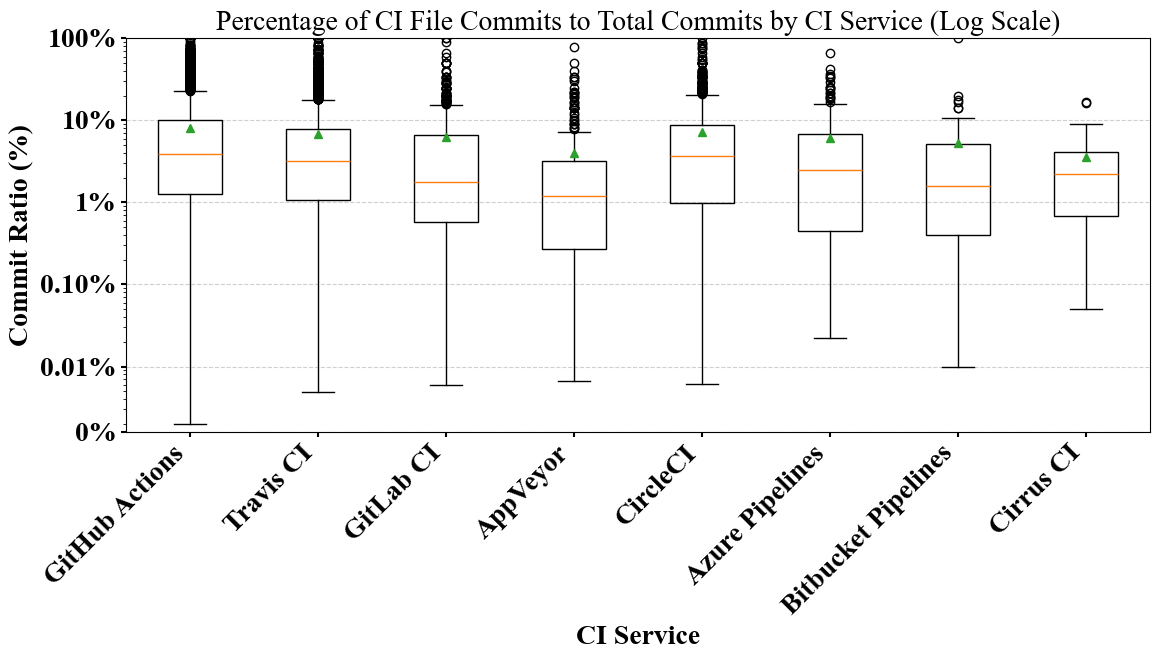

In [7]:
# Count CI commits per repo per CI service
ci_commit_counts = df_ci_commits.groupby(['repo_name', 'ci_service']).size().reset_index(name='ci_commits')

# Merge with total commit counts
merged = ci_commit_counts.merge(df_total_commits[['repo_name', 'commit_count']], on='repo_name', how='inner')

# Calculate ratio as percentage
merged['commit_ratio_pct'] = (merged['ci_commits'] / merged['commit_count']) * 100

# Remove invalid ratios (e.g., commit_count == 0)
merged = merged[merged['commit_count'] > 0]

# Stats per CI service (as percentage)
stats = merged.groupby('ci_service')['commit_ratio_pct'].agg(['mean', 'median', 'std', 'min', 'max', 'count']).round(2)
print(stats.applymap(lambda x: f"{x:.2f}%" if isinstance(x, float) else x))

# Box plot
plt.figure(figsize=(12, 7))
plt.rcParams['font.family'] = 'Times New Roman'

services = merged['ci_service'].unique()
box_data = [merged[merged['ci_service'] == s]['commit_ratio_pct'] for s in services]
bp = plt.boxplot(box_data, labels=services, patch_artist=True, showmeans=True)
colors = plt.cm.Set3(np.linspace(0, 1, len(services)))
for patch in bp['boxes']:
    patch.set_facecolor('none')

plt.title('Percentage of CI File Commits to Total Commits by CI Service (Log Scale)')
plt.xlabel('CI Service')
plt.ylabel('Commit Ratio (%)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.yscale('log')

# Find minimum positive value in box_data
min_val = min([d.min() for d in box_data if len(d) > 0 and d.min() > 0])
plt.ylim(min_val * 0.8, 100)  # Set lower limit just below minimum

# Custom ticks: "0%" at min_val * 0.8, then 1%, 10%, 100%
ticks = [min_val * 0.8, 0.01, 0.10, 1, 10, 100]
labels = ['0%', '0.01%', '0.10%', '1%', '10%', '100%']
plt.gca().set_yticks(ticks)
plt.gca().set_yticklabels(labels)

plt.tight_layout()
plt.savefig(os.path.join(results_path, 'commits_per_project_by_ci_service.pdf'), format='pdf', dpi=300)
plt.show()

##### Configuration Complexity (Visualization)

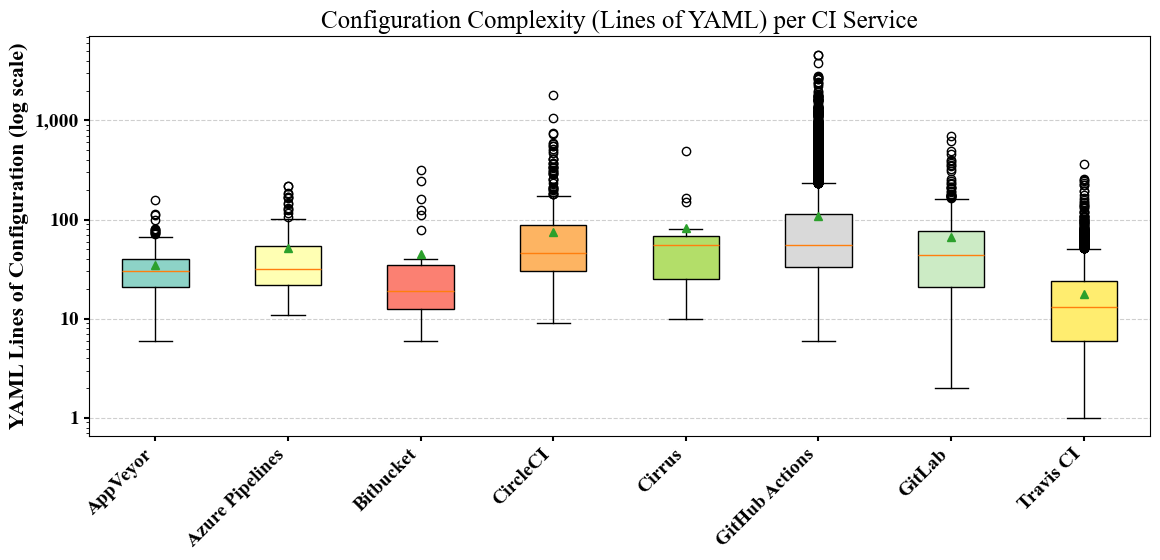

In [8]:
# Drop rows with missing values
df_yml_stats = df_yml_stats.dropna(subset=['ci_service', 'yml_lines_count'])

# Group YAML line counts by CI service
yml_stats_grouped = df_yml_stats.groupby('ci_service')['yml_lines_count'].apply(list)

# Prepare labels and data
labels = yml_stats_grouped.index.tolist()
data = yml_stats_grouped.values.tolist()

# Create box plot
plt.figure(figsize=(12, 6))
bp = plt.boxplot(data, patch_artist=True, showmeans=True)

# Color each box
colors = plt.cm.Set3(np.linspace(0, 1, len(labels)))
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

# Format axes
plt.xticks(ticks=np.arange(1, len(labels)+1), labels=labels, rotation=45, ha='right', fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('YAML Lines of Configuration (log scale)', fontsize=16)
plt.title('Configuration Complexity (Lines of YAML) per CI Service', fontsize=18)
plt.yscale('log')

# --- Patch: Format y-axis ticks as "1", "10", "100", "1,000" ---
def y_fmt(x, pos):
    if x >= 1:
        return '{:,.0f}'.format(x)
    else:
        return str(x)
plt.gca().yaxis.set_major_formatter(FuncFormatter(y_fmt))
# --------------------------------------------------------------

plt.grid(axis='y', linestyle='--', alpha=0.6)

# Save the plot
plt.tight_layout()
plt.savefig(os.path.join(results_path, 'ci_config_complexity_boxplot.pdf'), format='pdf')
plt.show()

##### Configuration Complexity (statistical differences across CI services)

In [9]:
stat, p = kruskal(*data)
print(f"Kruskal-Wallis H-statistic: {stat:.3f}, p-value: {p:.3e}")

pairs = list(itertools.combinations(range(len(labels)), 2))
pvals = []
for i, j in pairs:
    stat, p = mannwhitneyu(data[i], data[j], alternative='two-sided')
    pvals.append(p)

# Benjamini–Hochberg correction
reject, pvals_corrected, _, _ = multipletests(pvals, method='fdr_bh')

results = []
for idx, (i, j) in enumerate(pairs):
    results.append({
        'Group 1': labels[i],
        'Group 2': labels[j],
        'Raw p-value': pvals[idx],
        'Corrected p-value': pvals_corrected[idx],
        'Significant': 'Yes' if reject[idx] else 'No'
    })

results_df = pd.DataFrame(results)
results_df = results_df.sort_values('Corrected p-value')
results_df = results_df.round({'Raw p-value': 4, 'Corrected p-value': 4})

print(results_df)

Kruskal-Wallis H-statistic: 8250.299, p-value: 0.000e+00
            Group 1          Group 2  Raw p-value  Corrected p-value  \
26   GitHub Actions        Travis CI       0.0000             0.0000   
21         CircleCI        Travis CI       0.0000             0.0000   
27           GitLab        Travis CI       0.0000             0.0000   
6          AppVeyor        Travis CI       0.0000             0.0000   
12  Azure Pipelines        Travis CI       0.0000             0.0000   
4          AppVeyor   GitHub Actions       0.0000             0.0000   
2          AppVeyor         CircleCI       0.0000             0.0000   
25   GitHub Actions           GitLab       0.0000             0.0000   
15        Bitbucket   GitHub Actions       0.0000             0.0000   
10  Azure Pipelines   GitHub Actions       0.0000             0.0000   
19         CircleCI   GitHub Actions       0.0000             0.0000   
24           Cirrus        Travis CI       0.0000             0.0000   
13     

# RQ2

##### CI Service abandonment rate per CI service

In [10]:
# --- Abandonment Detection (Based on Config File Removal) ---

# Standardize column name if needed
if 'ci_services' in df_ci_existence.columns:
    df_ci_existence = df_ci_existence.rename(columns={'ci_services': 'ci_service'})

# Now dropna using the consistent column names
df_ci_existence = df_ci_existence.dropna(subset=['repo_name', 'ci_service', 'still_exists'])

# Keep only cases where the CI config was removed (abandoned)
abandoned = df_ci_existence[df_ci_existence['still_exists'] == False][['repo_name', 'ci_service']]
abandoned['status'] = 'abandoned'

# --- Obsolescence Detection (Based on Inactivity with Continued Repo Activity) ---

# Ensure datetime format and timezone-naive
df_ci_commits['author_date'] = pd.to_datetime(df_ci_commits['author_date'], errors='coerce')
df_ci_commits['author_date'] = df_ci_commits['author_date'].dt.tz_localize(None)

# Last commit on CI config per repo/service
last_commit_ci = df_ci_commits.groupby(['repo_name', 'ci_service'])['author_date'].max().reset_index()

# Last commit in repo overall
last_commit_repo = df_ci_commits.groupby('repo_name')['author_date'].max().reset_index()
last_commit_repo.rename(columns={'author_date': 'repo_last_commit_date'}, inplace=True)

# Merge for comparison
merged = pd.merge(last_commit_ci, last_commit_repo, on='repo_name', how='left')

# Calculate inactivity
ref_date = datetime(2024, 12, 31)
merged['inactivity_days'] = (ref_date - merged['author_date']).dt.days
inactivity_threshold = merged['inactivity_days'].quantile(0.25)  # use median or 0.75 if needed

# Mark as obsolete: CI config not updated + repo still active + not already abandoned
merged['status'] = None
merged.loc[
    (merged['repo_last_commit_date'] > merged['author_date']) &
    (merged['inactivity_days'] >= inactivity_threshold),
    'status'
] = 'obsolete'

# Remove entries already marked as abandoned
merged_filtered = merged[['repo_name', 'ci_service', 'status']]
merged_filtered = merged_filtered.dropna(subset=['status'])

# Combine abandonment and obsolescence, ensuring no duplicates
combined = pd.concat([abandoned, merged_filtered])
combined = combined.drop_duplicates(subset=['repo_name', 'ci_service'], keep='first')  # prioritize abandonment

# --- Summary per CI Service ---

# Count statuses
status_counts = combined.groupby(['ci_service', 'status']).size().unstack(fill_value=0)

# Add total per service (from existence + commit data)
total_counts = pd.concat([
    df_ci_existence[['repo_name', 'ci_service']],
    df_ci_commits[['repo_name', 'ci_service']]
]).drop_duplicates().groupby('ci_service').size()

# Build summary table
summary = status_counts.copy()
summary['Total'] = total_counts
summary['Abandoned %'] = (summary.get('abandoned', 0) / summary['Total'] * 100).round(2)
summary['Obsolete %'] = (summary.get('obsolete', 0) / summary['Total'] * 100).round(2)

# Sort and display
summary = summary.sort_values(by='Total', ascending=False)

print("Combined Abandonment and Obsolescence Summary per CI Service:")
for ci, row in summary.iterrows():
    abandoned = row.get('abandoned', 0)
    obsolete = row.get('obsolete', 0)
    total = row['Total']
    print(f"{ci}: {abandoned} abandoned ({row['Abandoned %']}%), {obsolete} obsolete ({row['Obsolete %']}%) out of {total}")


Combined Abandonment and Obsolescence Summary per CI Service:
GitHub Actions: 873.0 abandoned (7.35%), 175.0 obsolete (1.47%) out of 11884.0
Travis CI: 2573.0 abandoned (29.29%), 617.0 obsolete (7.02%) out of 8786.0
CircleCI: 493.0 abandoned (41.26%), 94.0 obsolete (7.87%) out of 1195.0
GitLab CI: 151.0 abandoned (28.22%), 70.0 obsolete (13.08%) out of 535.0
AppVeyor: 120.0 abandoned (44.61%), 69.0 obsolete (25.65%) out of 269.0
Azure Pipelines: 60.0 abandoned (37.04%), 21.0 obsolete (12.96%) out of 162.0
Bitbucket Pipelines: 24.0 abandoned (40.0%), 10.0 obsolete (16.67%) out of 60.0
Cirrus CI: 9.0 abandoned (33.33%), 2.0 obsolete (7.41%) out of 27.0


##### CI Switching (After how long a project starts to add a ci service )

In [11]:
# Ensure author_date is datetime and timezone-naive
df_ci_commits['author_date'] = pd.to_datetime(df_ci_commits['author_date'], errors='coerce')
df_ci_commits['author_date'] = df_ci_commits['author_date'].dt.tz_localize(None)

# Get first commit date per repo and CI service
first_commits = df_ci_commits.groupby(['repo_name', 'ci_service'])['author_date'].min().reset_index()

# Count total adopters per service
total_adopters = first_commits.groupby('ci_service')['repo_name'].nunique()

# Pivot for switching calculations
pivot = first_commits.pivot(index='repo_name', columns='ci_service', values='author_date')

switch_records = []
services = pivot.columns.tolist()

for repo, row in pivot.iterrows():
    present_services = row.dropna()
    sorted_services = present_services.sort_values()
    for i in range(len(sorted_services) - 1):
        from_service = sorted_services.index[i]
        to_service = sorted_services.index[i + 1]
        delta_days = (sorted_services.iloc[i + 1] - sorted_services.iloc[i]).days
        switch_records.append({
            'repo_name': repo,
            'from_service': from_service,
            'to_service': to_service,
            'switch_days': delta_days
        })

switch_df = pd.DataFrame(switch_records)

# Aggregate counts per from_service -> to_service pair
summary = switch_df.groupby(['from_service', 'to_service']).agg(
    count=('repo_name', 'size'),
    mean_days=('switch_days', 'mean'),
    median_days=('switch_days', 'median')
).reset_index()

# Add total adopters from 'from_service' to calculate ratio and percentage
summary['total_from_service'] = summary['from_service'].map(total_adopters)
summary['percentage'] = (summary['count'] / summary['total_from_service'] * 100).round(2)

# Calculate ratio: one in how many adopters switched
summary['switch_ratio'] = summary['total_from_service'] / summary['count']
summary['switch_ratio'] = summary['switch_ratio'].apply(lambda x: f"1 in {int(round(x))}")

# Sort by count descending
summary = summary.sort_values(by='count', ascending=False)

total_projects = df_ci_commits['repo_name'].nunique()
total_switched_projects = switch_df['repo_name'].nunique()
percentage_switched = (total_switched_projects / total_projects) * 100
print(f"Total projects that switched CI services: {total_switched_projects} ({percentage_switched:.2f}%)")

# Group by from_service and sum the counts
from_totals = summary.groupby('from_service')['count'].sum()
most_from = from_totals.idxmax()
most_from_count = from_totals.max()
from_total_all = from_totals.sum()
from_pct = most_from_count / from_total_all * 100

# Group by to_service and sum the counts
to_totals = summary.groupby('to_service')['count'].sum()
most_to = to_totals.idxmax()
most_to_count = to_totals.max()
to_total_all = to_totals.sum()
to_pct = most_to_count / to_total_all * 100

pd.set_option('display.max_columns', None)

print(f"Most common 'from' CI service: {most_from} ({most_from_count} switches, {from_pct:.1f}%)")
print(f"Most common 'to' CI service: {most_to} ({most_to_count} switches, {to_pct:.1f}%)")

overall_median_days = switch_df['switch_days'].median()
print(f"Overall median switch days: {overall_median_days} days")

# Total number of switches
total_switches = len(switch_df)

# Count of switches with switch_days <= 90
within_3_months = (switch_df['switch_days'] <= 121).sum()

# Compute percentage
percentage = (within_3_months / total_switches) * 100
print(f"Percentage of switches within 3 months: {percentage:.2f}%")

within_1_year = (switch_df['switch_days'] <= 365).sum()

percentage_within_1_year = (within_1_year / total_switches) * 100
print(f"Percentage of switches within 1 year: {percentage_within_1_year:.2f}%")

print("Summary of CI Service Switches:")
print(summary[['from_service', 'to_service', 'count', 'percentage', 'switch_ratio', 'mean_days', 'median_days']])

service_sequences = pivot.apply(lambda row: row.dropna().sort_values().index.tolist(), axis=1)
repos_with_switch_back = service_sequences[service_sequences.apply(lambda seq: len(seq) != len(set(seq)))]
print(f"Number of projects switching back to a previous service: {len(repos_with_switch_back)}")

Total projects that switched CI services: 3430 (18.15%)
Most common 'from' CI service: Travis CI (2802 switches, 71.5%)
Most common 'to' CI service: GitHub Actions (2915 switches, 74.4%)
Overall median switch days: 879.0 days
Percentage of switches within 3 months: 19.95%
Percentage of switches within 1 year: 30.24%
Summary of CI Service Switches:
           from_service           to_service  count  percentage switch_ratio  \
39            Travis CI       GitHub Actions   2273       25.90       1 in 4   
16             CircleCI       GitHub Actions    329       27.60       1 in 4   
37            Travis CI             CircleCI    270        3.08      1 in 32   
34            Travis CI             AppVeyor    152        1.73      1 in 58   
32            GitLab CI       GitHub Actions    124       23.53       1 in 4   
3              AppVeyor       GitHub Actions     92       34.20       1 in 3   
28       GitHub Actions            Travis CI     92        0.78     1 in 128   
18        

##### Developer Engagement in CI Configuration (Author to Contributor Ratio)


Statistics for each CI service:
                      mean  median    std
ci_service                               
AppVeyor             0.300   0.167  0.332
Azure Pipelines      0.400   0.250  0.373
Bitbucket Pipelines  0.341   0.250  0.333
CircleCI             0.441   0.333  0.373
Cirrus CI            0.280   0.243  0.266
GitHub Actions       0.474   0.357  0.350
GitLab CI            0.356   0.250  0.339
Travis CI            0.457   0.333  0.374


/var/folders/m2/9fsh9ts55113x52y_lp1p_nr0000gn/T/ipykernel_81008/3967680668.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot([merged_data[merged_data['ci_service'] == service]['author_ratio']


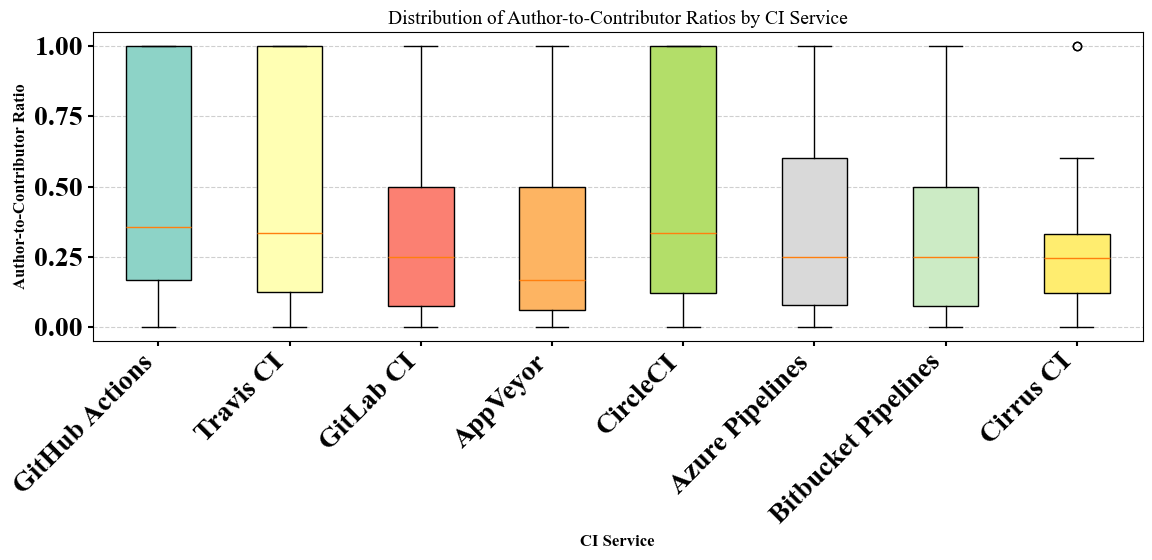

In [12]:
# Count unique contributors per repo from java_contributors.csv
contributors_per_repo = contributors_data.groupby('repo_name')['login'].nunique()

# Get unique authors per repo and CI service from CI data
authors_per_ci = (
    df_ci_commits.groupby(['repo_name', 'ci_service'])['author_login']
    .nunique()
    .reset_index(name='unique_authors')
)

# Merge with contributors count
merged_data = authors_per_ci.merge(
    contributors_per_repo.reset_index().rename(columns={'login': 'total_contributors'}), 
    on='repo_name', 
    how='inner'
)

# Calculate ratio
merged_data['author_ratio'] = merged_data['unique_authors'] / merged_data['total_contributors']
merged_data = merged_data[merged_data['author_ratio'] <= 1]  # Remove invalid ratios (cleaning step to ensure ratios are sensible)

# Calculate statistics per CI service
stats = merged_data.groupby('ci_service')['author_ratio'].agg(['mean', 'median', 'std']).round(3)
print("\nStatistics for each CI service:")
print(stats)

# Create box plot
plt.figure(figsize=(12, 6))
bp = plt.boxplot([merged_data[merged_data['ci_service'] == service]['author_ratio'] 
                  for service in merged_data['ci_service'].unique()],
                 labels=merged_data['ci_service'].unique(),
                 patch_artist=True)

# Customize box colors
colors = plt.cm.Set3(np.linspace(0, 1, len(merged_data['ci_service'].unique())))
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

plt.title('Distribution of Author-to-Contributor Ratios by CI Service', fontsize=14)
plt.xlabel('CI Service', fontsize=12)
plt.ylabel('Author-to-Contributor Ratio', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()

# Save the plot
plt.savefig(os.path.join(results_path, 'author_contributor_ratio_boxplot.pdf'), format='pdf')
plt.show()